I follow both Elon Musk and Bored Elon Musk on Twitter. Sometimes when I scroll through my timeline I see a tweet from Elon Musk and think, "that's crazy talk". Other times I read a tweet from Bored Elon Musk and think, "this is so crazy it might work".

<img src="elon_tweet.jpg" width="500">

I use the tweepy library to grab tweets for Elon Musk (https://twitter.com/elonmusk) and Bored Elon Musk (https://twitter.com/BoredElonMusk) via the Twitter API. I will then use some classification algorithms to classify the tweets as real or fake. For now I just use a Multinomial Naive Bayes classifier. **_My theory is that it shouldn't be that easy for the algorithm to identify real Elon Musk tweets. I expect more false classifications and a lower accuracy score than is "acceptable" when we actually want to predict things well._**

The first step is to create an app on the Twitter Developer platform in order to generate consumer and access keys. These will allow you to access the Twitter API through tweepy. These keys are specific to your Twitter Developer and/or user account, and so they should be kept private. I generally like to put them in a config.py file and import them. If you put your code on github, you can create a config_example.py file which will show other developers how to set up their config.py file. Also, make sure to add config.py to your .gitignore file.

In [1]:
from config import consumer_key, consumer_secret, access_token, access_token_secret
import tweepy

%matplotlib inline
import matplotlib.pyplot as plt
import datetime
import numpy as np
import pandas as pd
import seaborn as sns; sns.set()

In [2]:
# Creating the authentication object
auth = tweepy.OAuthHandler(consumer_key, consumer_secret)
# Setting your access token and secret
auth.set_access_token(access_token, access_token_secret)
# Creating the API object while passing in auth information
api = tweepy.API(auth) 

## Function to grab a user's tweets

Don't you love when you can write a function to keep your code DRY? I know I do.

In [3]:
def get_tweets(listOfTweets, user, numOfTweets):
    # Iterate through all tweets of specific user
    for tweet in tweepy.Cursor(api.user_timeline, id=user).items(numOfTweets):
        # Add tweets in this format
        dict_ = {'Screen Name': tweet.user.screen_name,
                'Tweet Created At': pd.to_datetime(tweet.created_at),
                'Tweet Text': tweet.text,
                }
        listOfTweets.append(dict_)   

## Grab tweets from both accounts

I decided to get 1000 tweets from each account. Ideally I would want more but both of these accounts don't tweet as much as, say, Donald Trump. I've listed 5 tweets from each account below. A lot of the real Elon Musk's tweets are replies or retweets. Those will be taken care of when I clean up the text.

In [4]:
data = []

get_tweets(data, 'BoredElonMusk', 1000)
get_tweets(data, 'elonmusk', 1000)
data_df = pd.DataFrame(data)

In [5]:
data_df.head()

,Screen Name,Tweet Created At,Tweet Text
0,BoredElonMusk,2019-06-27 01:11:51,RT @BoredElonMusk: Podiums with built-in stun ...
1,BoredElonMusk,2019-06-25 04:21:26,Coffee shop that gives you extra strong drinks...
2,BoredElonMusk,2019-06-19 16:01:04,"Ticketmaster, but not evil."
3,BoredElonMusk,2019-06-08 21:08:51,Blanket that absorbs and transfers heat from o...
4,BoredElonMusk,2019-06-06 14:52:12,Phone feature that rings your alarm just befor...


In [6]:
data_df.tail()

,Screen Name,Tweet Created At,Tweet Text
1995,elonmusk,2019-04-06 17:49:52,@flcnhvy @DMC_Ryan Almost done
1996,elonmusk,2019-04-06 17:42:30,@DMC_Ryan Are you on Mad Max Mode? This may be...
1997,elonmusk,2019-04-06 17:38:11,@DrCamiloOrtiz @TheGodOfPegana @Tesla Radar
1998,elonmusk,2019-04-06 17:29:58,@BjornWF @Tesla Sure
1999,elonmusk,2019-04-06 16:58:46,@fatropea @dani190 Exactly


## Cleaning tweet text

Tweets can be alphabet soup. Luckily, there are ways to clean up the text using regular expressions (my favourite!!!) and Beautiful Soup. I'm looking to clean up by doing the following:

1. Remove mentions/replies ("@") and retweets ("RT")
2. Convert HTML encoding to characters ("&amp" to "&")
3. Remove hyperlinks
4. Remove foreign languages (I saw some Russian???)
5. Remove hashtags and numbers

Shout out to [this post](https://towardsdatascience.com/another-twitter-sentiment-analysis-bb5b01ebad90) for giving me this list.

In [7]:
data_df['tweet_cleaned'] = data_df['Tweet Text']

pat1 ='RT @[\w_]+: '
pat2 = r'@[A-Za-z0-9]+'
pat3 = r'https?://[A-Za-z0-9./]+'
pat4 = r'[^a-zA-Z ]+'
combined_pat = r'|'.join((pat1, pat2, pat4))

from bs4 import BeautifulSoup
data_df['tweet_cleaned'] = data_df.tweet_cleaned.str.replace(pat3, '')
data_df['tweet_cleaned'] = [BeautifulSoup(text, 'lxml').get_text() for text in data_df['tweet_cleaned'] ]
data_df['tweet_cleaned'] = data_df.tweet_cleaned.str.replace(combined_pat, '')
data_df.head()

,Screen Name,Tweet Created At,Tweet Text,tweet_cleaned
0,BoredElonMusk,2019-06-27 01:11:51,RT @BoredElonMusk: Podiums with built-in stun ...,Podiums with builtin stun guns that go off aft...
1,BoredElonMusk,2019-06-25 04:21:26,Coffee shop that gives you extra strong drinks...,Coffee shop that gives you extra strong drinks...
2,BoredElonMusk,2019-06-19 16:01:04,"Ticketmaster, but not evil.",Ticketmaster but not evil
3,BoredElonMusk,2019-06-08 21:08:51,Blanket that absorbs and transfers heat from o...,Blanket that absorbs and transfers heat from o...
4,BoredElonMusk,2019-06-06 14:52:12,Phone feature that rings your alarm just befor...,Phone feature that rings your alarm just befor...


## Create training and test data sets and then create text features

What would we do without scikit-learn? I use the lovely `train_test_split` function to split my data into training and test samples. The training data has 1500 tweets while the test data has 500 tweets. I also use the `feature_extraction` module to get word counts for each tweet, and convert the word counts into TF-IDF (term frequency-inverse document frequency) space. I also make use of pipelines so I can apply transformations and estimate the model all at once.

In [8]:
from sklearn.model_selection import train_test_split

X = data_df['tweet_cleaned']
y = data_df['Screen Name']
Xtrain, Xtest, ytrain, ytest = train_test_split(X, y, random_state=1991)

In [9]:
# convert content of string into vector of numbers using TF-IDF
# use pipeline to attach vectorized text data to multinomial bayes classifier
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import make_pipeline

model = make_pipeline(TfidfVectorizer(), MultinomialNB())

In [10]:
# apply model to training data and predict labels for test data
model.fit(Xtrain, ytrain)
ypred = model.predict(Xtest)

In [11]:
# need to see how the classifier orders the classes so I can use them for the confusion matrix
labels = model.classes_
labels.tolist()

['BoredElonMusk', 'elonmusk']

## Model evaluation: confusion matrix and accuracy score

The confusion matrix shows the number of correct and incorrect predictions on the test data set. The accuracy score is just the proportion of correct predictions. It would appear that tweets from BoredElonMusk are easier to classify, with 234 correct predictions out of 258. There were 206 correct predictions on tweets from Elon Musk out of 242.

The accuracy score is 0.88, which isn't bad if you just want anything better than a coin flip. I'm sure there are a bunch of rabid data scientists out there who hate this measure. Note to self: read [this](https://stats.stackexchange.com/questions/312780/why-is-accuracy-not-the-best-measure-for-assessing-classification-models) later. 

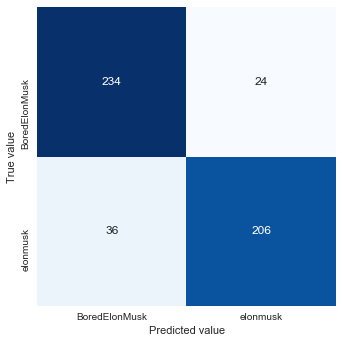

In [12]:
from sklearn.metrics import confusion_matrix
from sklearn.utils.multiclass import unique_labels

labels = model.classes_

mat = confusion_matrix(ytest, ypred)
sns.heatmap(mat, square=True, annot=True, cbar=False, cmap='Blues', fmt='g', 
            xticklabels=labels.tolist(), yticklabels=labels.tolist())
plt.xlabel('Predicted value')
plt.ylabel('True value');

In [13]:
# see fraction of predicted labels that match their true value
from sklearn.metrics import accuracy_score
accuracy_score(ytest, ypred)

0.88

## And now for something completely different... 

What would this post be without a **_word cloud_**!?!?

In [14]:
import sys
!{sys.executable} -m pip install wordcloud

You are using pip version 18.1, however version 19.1.1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


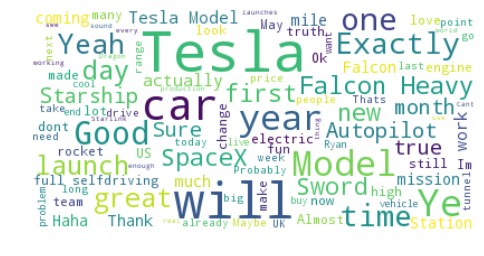

In [15]:
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

bored_elon = data_df[data_df['Screen Name'] == 'BoredElonMusk']
elon = data_df[data_df['Screen Name'] == 'elonmusk']

stop_words = ['BoredElonMusk', 'elonmusk', 'youre'] + list(STOPWORDS)
    
# Create and generate a word cloud image:
wordcloud = WordCloud(max_font_size=50, max_words=100, background_color="white", 
                      stopwords=stop_words).generate(' '.join(elon['tweet_cleaned']))

# Display the generated image:
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

It would appear that real Elon Musk talks a lot about Tesla. That probably bodes well for his shareholders. Focus, right? Bored Elon Musk seems to care about services and apps.

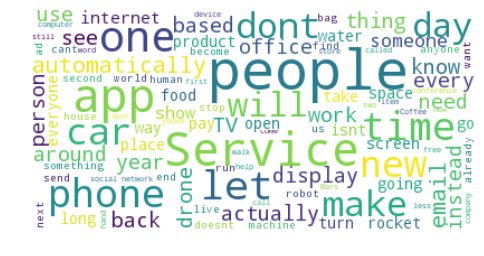

In [16]:
# Create and generate a word cloud image:
wordcloud = WordCloud(max_font_size=50, max_words=100, background_color="white", 
                      stopwords=stop_words).generate(' '.join(bored_elon['tweet_cleaned']))

# Display the generated image:
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()